# HW #5 Practice Worksheet: Animacy

As practice for HW #5, this Python notebook uses NLTK's feature structure syntax to 

## Helper Functions

One of the powers of using a notebook like this is that is essentially an interpreter, so we can treat it like an interactive sandbox, with some helpful visualization tools as well. Let's 

In [8]:
import nltk, re

def init_parser(grammar_str):
    """
    Initialize a feature parser based on the input grammar string.
    """
    grammar = nltk.grammar.FeatureGrammar.fromstring(grammar_str)
    return nltk.parse.FeatureIncrementalChartParser(grammar)

def word_tokenize(sent):
    # If you are receiving the "punkt" error, uncomment
    # the following line -- it's not as good a tokenizer
    # but it will function without nltk downloads:
    # return re.split('\s+', sent)
    return nltk.tokenize.word_tokenize(sent)

def init_sents(sent_str):
    """
    Parse in a series of sentences, and their acceptability notation
    as a tuple of (is_valid, sent).
    """
    for sent in [s.strip() for s in sent_str.split('\n') if s.strip()]:
        is_valid = not sent.startswith('*')
        tokens = nltk.tokenize.word_tokenize(re.sub('^\*?\s*', '', sent))
        yield is_valid, tokens

# A few IPython visualization tools
from IPython.core.display import display_html, display_png
def csscolor(s, c): return '<span style="color: {};">{}</span>'.format(c, s)
def html(s): display_html(s, raw=True)
    
def check_coverage(grammar_str, sent_str):
    """
    A helper function to iterate over our defined grammar and sentence key,
    and tell us whether or not we got the answer right for the given sentence.
    
    :type sent_list: list[str]
    """
    ret_str = ''
    parser = init_parser(grammar_str)
    for is_valid, tokens in init_sents(sent_str):
        valid_marker = '' if is_valid else '&#42; '
        sent_repr = '{}{}'.format(valid_marker, ' '.join(tokens))
        
        def sent_error(extra=''):
            html('\u274C &nbsp;' + csscolor(sent_repr + extra, 'red'))
        def sent_success(extra=''):
            html('\u2705 &nbsp;' + csscolor(sent_repr + extra, 'green'))
        try:
            parses = list(parser.parse(tokens))
        except ValueError as ve:
            html('\u274C ' + csscolor(str(ve), 'red'))
            continue
        
        if not parses:
            if is_valid:
                sent_error()
            else:
                sent_success()
        else:
            first_parse = ' {}'.format(parses[0])
            if is_valid:                   
                sent_success(str(parses[0]))
            else:
                sent_error(str(parses[0]))
            # Comment out the following line if you're receiving
            # a "tkinter" error:
            display_png(parses[0])
            
    display_html(ret_str, raw=True)

# Practice

Now that we've got the helper functions out of the way, let's get down to defining our grammar.

Here, we're going to look at how some verbs seem to expect certain of their arguments to have animacy, as expressed by the following sentences:

* *Alex gifted Ahmed a book*
* <span style="color:red">\* *Alex gifted the rock a book*</span>

*(with thanks to Shannon for suggesting it)* — *"**made**,"* on the other hand, does not have such a distinction and can have this requirement left unspecified.

* *Alex made Ahmed a hat*
* *Alex made the rock a hat*

If Alex is our friend, this might be cause to worry about Alex, but it doesn't seem like a semantically invalid thing to say.

Let's see if we can figure out how to provide an analysis that accepts *"Ahmed"* as an indirect object for gifted, but not *"the rock*", and an analysis that accepts either as an indirect object for *"made"*

<small>*...although for an added challenge, add an analysis for the +animacy version of "The Rock" that goes by "Dwayne.""*</small>


✅   Alex gifted Ahmed a book(S[]
 (NP[+animacy] (NNP[+animacy] Alex))
 (VP[]
 (V[+indobj_animacy] gifted)
 (NP[+animacy] (NNP[+animacy] Ahmed))
 (NP[-animacy] (Det[] a) (N[-animacy] book))))

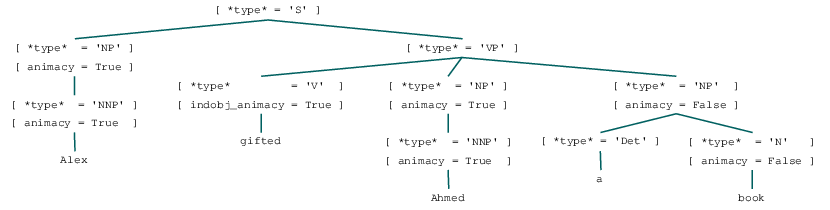

✅   * Alex gifted the rock a book

✅   Alex made the rock a hat(S[]
 (NP[+animacy] (NNP[+animacy] Alex))
 (VP[]
 (V[] made)
 (NP[-animacy] (Det[] the) (N[-animacy] rock))
 (NP[-animacy] (Det[] a) (N[-animacy] hat))))

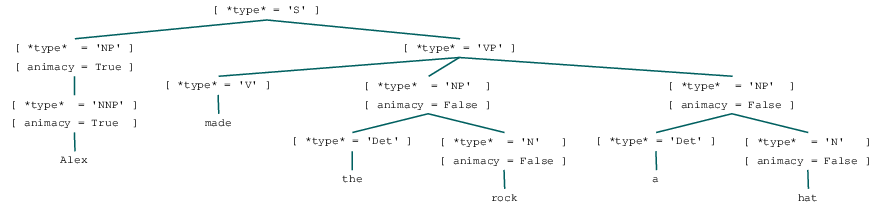

✅   Alex made Ahmed a hat(S[]
 (NP[+animacy] (NNP[+animacy] Alex))
 (VP[]
 (V[] made)
 (NP[+animacy] (NNP[+animacy] Ahmed))
 (NP[-animacy] (Det[] a) (N[-animacy] hat))))

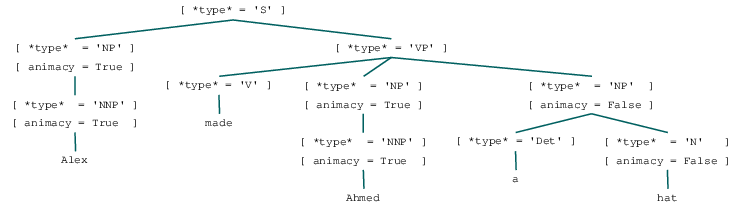

In [15]:
sentences = '''
Alex gifted Ahmed a book
*Alex gifted the rock a book
Alex made the rock a hat
Alex made Ahmed a hat
'''

grammar='''%start S
S -> NP VP

# In this analysis, we specify that a verb
# with direct_object animacy
VP -> V[indobj_animacy=?oa] NP[animacy=?oa] NP

NP[animacy=?a] -> NNP[animacy=?a]
NP[animacy=?a] -> Det N[animacy=?a]

NNP[animacy=True] -> 'Alex' | 'Ahmed'
V[indobj_animacy=True] -> 'gifted'
V -> 'made'
Det -> 'a' | 'the'
N[animacy=False] -> 'book' | 'rock' | 'hat'
'''

check_coverage(grammar, sentences)

✅   Ahmed gifted The The Rock a book(S[]
 (NP[+animacy] (NNP[+animacy] Ahmed))
 (VP[]
 (V[+indobj_animacy] gifted)
 (NP[animacy=?a]
 (NNP[animacy=?n]
 (NNP[animacy=?n]
 (NNP[+animacy] The)
 (NNP_BAR[] (NNP[+animacy] The)))
 (NNP_BAR[] (NNP[+animacy] Rock))))
 (NP[-animacy] (Det[] a) (N[-animacy] book))))

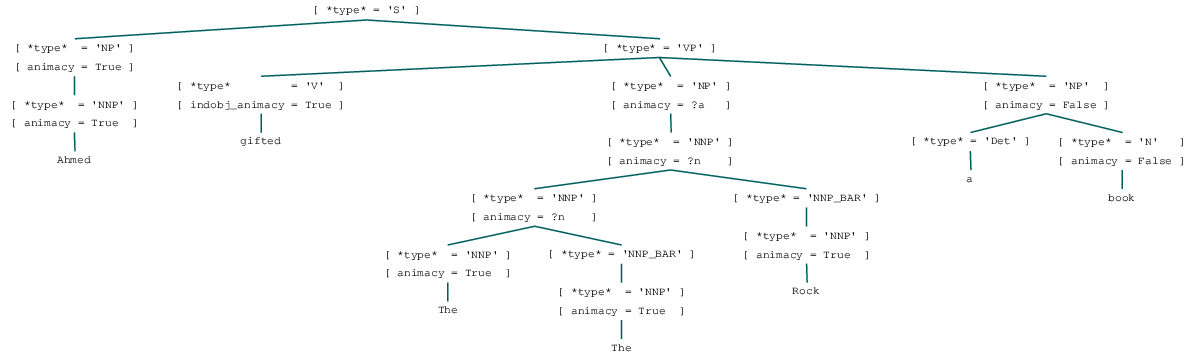

✅   * Ahmed gifted the rock a book

In [16]:
# What can I say, except 'you're welcome'?
dwayne_sentence = '''
Ahmed gifted The The Rock a book
*Ahmed gifted the rock a book
'''

dwayne_grammar = grammar + '''
NNP[animacy=?n] -> NNP NNP_BAR 
NNP_BAR -> NNP
NNP[animacy=True] -> 'The' | 'Rock'
'''

check_coverage(dwayne_grammar, dwayne_sentence)